# 1. Research Description

This study investigates whether certain groups formed using clustering methods based on financial and chategorical characteristics - show distinct patterns. Through further hypothesis testing the main research question is then further refined into a personal research question.

Main research question: How do product, customer and transactional characteristics interact to influence the overall profitability and sales performance of this company's business operations?

To address this research question, the analysis examines how product characteristics and transactional patterns influence profitability and sales performance. Using a combination of clustering techniques and descriptive analytics, products are segmented based on shared financial and behavioral profiles, allowing us to identify profit-driving segments, loss-making groups, and underlying patterns such as seasonality, stability, and category-specific dynamics. These results provide a structured and data-driven understanding of the key factors shaping business performance and support informed decision-making for assortment, pricing, and operational improvements.

Note: During the development of the analytical workflow, AI-based tools (ChatGPT) were used to refine code structure, enhance clarity, and validate methodological choices. The analytical logic, interpretation, and implementation remain researcher-driven; AI assistance served only as a supportive tool, not as a source of copied content.

Personal Research Question: Is there a significant relationship between profit/loss and purchase volume across customer segments?

The following hypotheses have been created to test this:
H0: There is no significant relationship between purchase volume and profit/loss across all segments
HA: There is a significant relationship between purchase volumen and profit/loss across all segments


## 1.1 EDA Per Dataset

In this first section of the report, an (EDA) Exploratory Data Analysis is done. The goal of the EDA is to understand the structure, quality and data within the Item Features Parquet. 

The EDA is divided into three sections:
1) Item Features EDA
2) User Transactions EDA
3) Data Preparation

In [43]:
#Import Libraries -- IGNORE ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import f_oneway, kruskal
from semopy import Model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from kneed import KneeLocator

#Read Files -- IGNORE ---
df_item_features = pd.read_parquet('Tao Yin_Item_features.parquet')
df_user_transactions = pd.read_parquet('TaoYin_User_Transactions_v2.parquet')

## 1.2 Item Features EDA
This section explores the product-level dataset containing individual item features such as article numbers, engineered features and product classifications.

In [44]:
#EDA Item Features
print(df_item_features.info())
print(df_item_features.shape)
display(df_item_features.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168939 entries, 0 to 168938
Columns: 4028 entries, Articlenr to statistiek_subgroep
dtypes: float64(4025), int64(1), object(2)
memory usage: 5.1+ GB
None
(168939, 4028)


,Articlenr,EF000001,EF000002,EF000003,EF000004,EF000005,EF000006,EF000007,EF000008,EF000010,...,EFDE0031,EFDE0032,EFFR0001,EFFR0002,EFNL0014,EFUK0017,EFUK0019,ETIM,statistiek_hoofdgroep,statistiek_subgroep
0,34581962,6.0,NaN,NaN,NaN,NaN,NaN,NaN,6.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,A,x1
1,35764300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,A,x2
2,35823358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,A,x3
3,28405226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,321.0,B,y1
4,35622440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,C,y2


### 1.2.1 Distribution of Feature-Available and Active Items
In the section below an overview is provided in order to better understand the number of items available in both datasets and to better capture what types of items exist in both datasets.

Total Items in Item Features: 166228
Feature-Available Items in Item Features: 164554
Feature-Unavailable Items in Item Features: 1674

Total Items in User Transactions: 19291
Unique Items sold (At Least One Transaction): 7871
Unique Items missing from invoices (No Transactions): 158357


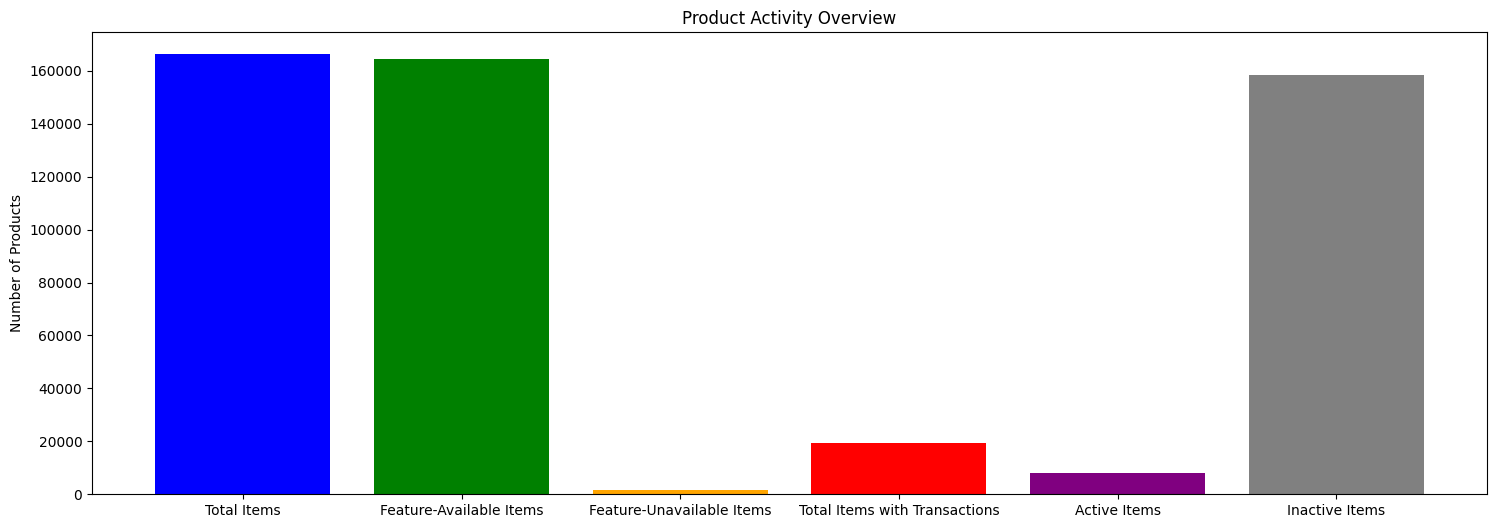

In [45]:
#Data Preprocessing -- IGNORE ---
df_item_features["Articlenr"]     = df_item_features["Articlenr"].astype(str).str.strip()
df_user_transactions["articlenr"] = df_user_transactions["articlenr"].astype(str).str.strip()

#Total amount of unique items = Total Items
total_products = df_item_features['Articlenr'].nunique()

#Identify feature-available items
features_columns = [col for col in df_item_features.columns if col.startswith('EF')]
active_mask = df_item_features[features_columns].notna().any(axis=1)
active_products = df_item_features.loc[active_mask, 'Articlenr'].nunique()
inactive_products = total_products - active_products

#Total items in user transactions
total_products_sold = df_user_transactions['articlenr'].nunique()
sold_products = pd.Index(df_user_transactions['articlenr'].dropna().unique())

# Flag in the items table + counts
df_item_features["item_sold"] = df_item_features["Articlenr"].isin(sold_products)

# Unique items that were sold (and exist in your items table)
unique_sold = df_item_features.loc[df_item_features["item_sold"], "Articlenr"].nunique()
never_sold  = total_products - unique_sold

#Print outputs -- IGNORE ---
print('Total Items in Item Features:', total_products)
print('Feature-Available Items in Item Features:', active_products)
print('Feature-Unavailable Items in Item Features:', inactive_products)
print("")
print('Total Items in User Transactions:', total_products_sold)
print("Unique Items sold (At Least One Transaction):", unique_sold)
print("Unique Items missing from invoices (No Transactions):", never_sold)

product_histogram = plt.figure(figsize=(18, 6))
labels = ['Total Items', 'Feature-Available Items', 'Feature-Unavailable Items', 'Total Items with Transactions', 'Active Items', 'Inactive Items']
values = [total_products, active_products, inactive_products, total_products_sold, unique_sold, never_sold]
plt.bar(labels, values, color=['blue', 'green', 'orange', 'red', 'purple', 'gray'])
plt.title('Product Activity Overview')
plt.ylabel('Number of Products')
plt.show()

The bar chart and output above provides an overview of all items within the Item Features and User Transactions dataset. Products with at least one active feature are labelled as Feature-Available Items and those without are labeled as Feature-Unavailable Items. 

The definition for active items is any items with at least one trasaction available, those without transactions are labeled as inactive. 

### 1.2.2 Distribution of Items based on Product Category (statistiek_hoofdgroep)
To further understand the distribution of items, a bar chart is created to see which active items belong to which product category 

Number of main categories: 9
Number of subcategories: 46


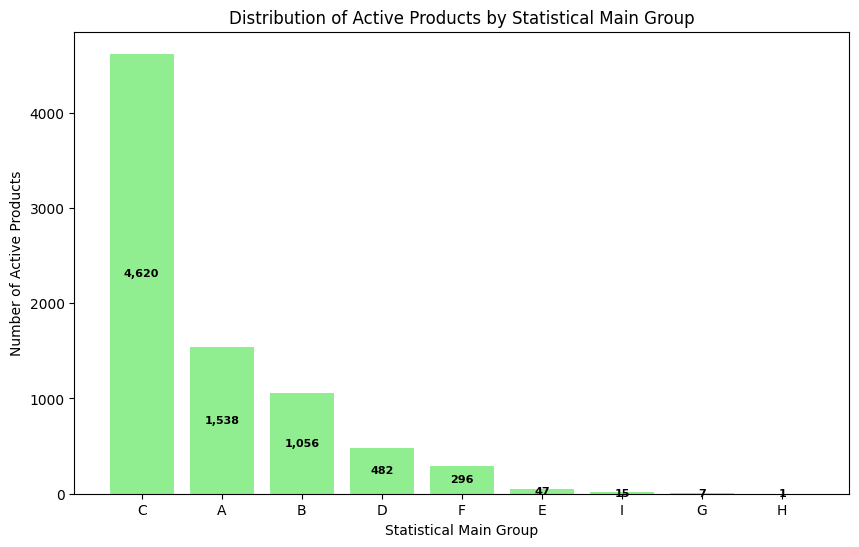

In [46]:
#Products by statistical main group
main_categories = df_item_features['statistiek_hoofdgroep'].unique()
subcategories = df_item_features['statistiek_subgroep'].unique()

print("Number of main categories:", len(main_categories))
print("Number of subcategories:", len(subcategories))

#Distribution of active items by product category
#Add product category to user transactions
df_user_transactions = df_user_transactions.rename(columns={'articlenr': 'Articlenr'})
df_user_transactions_with_categories = df_user_transactions.merge(df_item_features[['Articlenr', 'statistiek_hoofdgroep']], on='Articlenr', how='left')

#Create a dataframe
unique_sold = df_item_features.loc[df_item_features["item_sold"], "Articlenr"].unique()
df_sold_items = pd.DataFrame(unique_sold, columns=['Articlenr'])

#Merge columns and count items
df_user_transactions_with_categories = df_sold_items.merge(df_item_features[['Articlenr', 'statistiek_hoofdgroep']], on='Articlenr', how='left')
active_category_counts = df_user_transactions_with_categories['statistiek_hoofdgroep'].value_counts().sort_values(ascending=False)

#Plot distribution of active products by statistical main group
plt.figure(figsize=(10, 6))
bars = plt.bar(active_category_counts.index, active_category_counts.values, color='lightgreen')
for bar, count in zip(bars, active_category_counts.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        f'{count:,}',
        ha='center', va='center', color='black', fontsize=8, weight='bold'
    )
plt.title('Distribution of Active Products by Statistical Main Group')
plt.xlabel('Statistical Main Group')
plt.ylabel('Number of Active Products')
plt.show()


The output and bar chart above shows the distribution of active items across different statistical main groups. This helps identify which categories have the most active items, providing insights into product focus areas. From it, the item catalogue can shown to be mainly made up of products from the Category C Statistical Main Group.

### 1.2.3 Most active features among active items
Now that the distribution of items and their classifications are known. It is also best to identify which features are present within the active items. The top 10 features are identified and displayed herebelow.

EF000008    3587
EF000007    3493
EF005474    3211
EF002169    3127
EF000040    2877
EF000049    2300
EF000139    2037
EF000003    1970
EF000010    1926
EF001257    1874
dtype: int64

Text(0, 0.5, 'Number of Feature-Available Active Items')

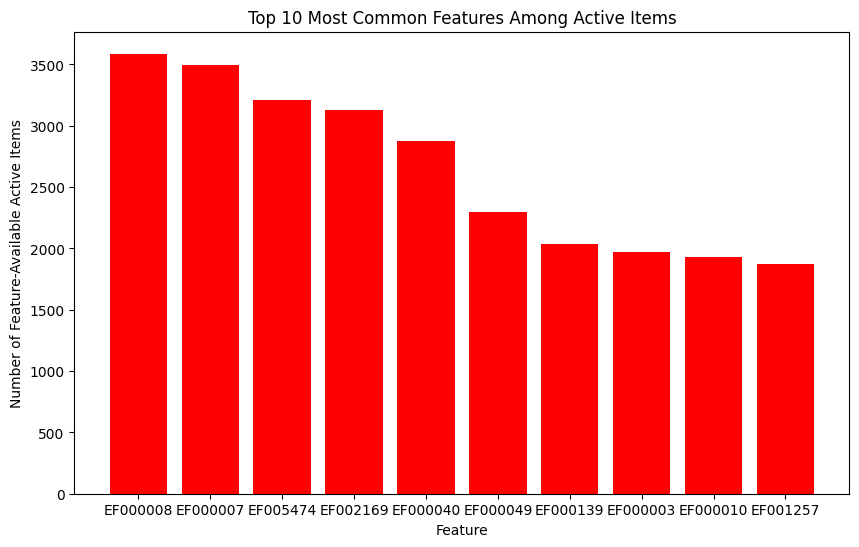

In [47]:
#Most common features among active items
#Cross-check item features and active status
df_sold_10_items = df_item_features[df_item_features['Articlenr'].isin(sold_products)]
sold_feature_available_mask = df_sold_10_items[features_columns].notna().any(axis=1)
df_sold_features_available = df_sold_10_items[sold_feature_available_mask]

#Count of feature-available items
feature_counts_sold = df_sold_features_available[features_columns].notna().sum().sort_values(ascending=False)

top_10_features_sold = feature_counts_sold.head(10)
display(top_10_features_sold)

#Plot figure
plt.figure(figsize=(10, 6))
plt.bar(top_10_features_sold.index, top_10_features_sold.values, color='red')
plt.title('Top 10 Most Common Features Among Active Items')
plt.xlabel('Feature')
plt.ylabel('Number of Feature-Available Active Items')


From the graph and output below, the most popular features can be seen. EF000008 and EF000007 are the most popular with them being implemented in over 3,000 products each.

## 1.3 User Transaction EDA
The User Transaction dataset provides insight into individual purchase behaviors across customers, invoices and sales channels. The EDA confirms that there is enough data for segmentation.

In [48]:
#EDA User Transactions
print(df_user_transactions.info())
display(df_user_transactions.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492731 entries, 0 to 492730
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   customer           492731 non-null  int64         
 1   invoice            492731 non-null  int64         
 2   invoice_date       492731 non-null  datetime64[ns]
 3   Articlenr          492731 non-null  object        
 4   volume             492731 non-null  int64         
 5   sum1               492731 non-null  float64       
 6   sum2               492731 non-null  float64       
 7   postcode_delivery  492731 non-null  int64         
 8   postcode_customer  492731 non-null  int64         
 9   channel            492731 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 37.6+ MB
None


,customer,invoice,invoice_date,Articlenr,volume,sum1,sum2,postcode_delivery,postcode_customer,channel
0,2284,1187467,2020-01-02,32879960,24,343.73,362.30,80413,80413,Tel 86041
1,2284,1187467,2020-01-02,32879962,60,1067.64,1119.96,80413,80413,Tel 86041
2,2284,1187467,2020-01-02,32841810,120,2214.00,2408.40,80413,80413,Tel 86041
3,1704,1191447,2020-01-17,36866802,1,21.52,19.32,81724,81724,OTC 81812
4,45,1187691,2020-01-03,34360272,4,28.91,28.49,81796,81796,Web Order


### 1.3.1 Distribution of Channels, Top Sold Items and Count of Unique Customers
Before any data can be analysed, it is necessary to know the counts of transactions and customers available within the user transactions dataset. Below the number of unique customers, unique channels and the top 10 most purchased products.

Number of unique customers: 1070
Number of unique invoices: 95498
Number of unique channels (raw): 20
Number of unique channels (cleaned): 6

Top 10 most purchased products:


Articlenr
34382266    3605
32203604    2811
32203620    2617
34380024    2502
34380140    2342
34380030    2239
32608546    2152
34380220    2127
32607494    1971
34280014    1941
Name: count, dtype: int64

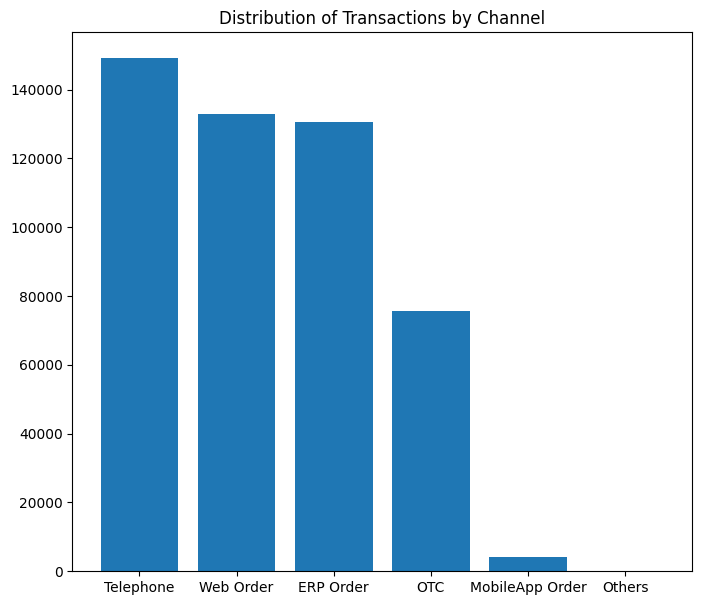

In [49]:
#Number of unique customer IDs
unique_customers = df_user_transactions['customer'].nunique()
print("Number of unique customers:", unique_customers)

#Number of unique invoices
unique_invoices = df_user_transactions['invoice'].nunique()
print("Number of unique invoices:", unique_invoices)

#Merge OTC and Tel channels 
def simplify_channel(x):
    if pd.isna(x):
        return 'Unknown'
    x_string = str(x).strip()
    x_lower = x_string.lower()
    if x_lower.startswith('otc'):
        return 'OTC'
    elif x_lower.startswith('tel'):
        return 'Telephone'
    else:
        return x_string

#Apply channel simplification
df_user_transactions['channel_cleaned'] = df_user_transactions['channel'].apply(simplify_channel)

#Number of channels (raw vs clean)
unique_channels_raw = df_user_transactions['channel'].nunique()
unique_channels_clean = df_user_transactions['channel_cleaned'].nunique()
print("Number of unique channels (raw):", unique_channels_raw)
print("Number of unique channels (cleaned):", unique_channels_clean)
print("")

#Top 10 most purchased products
top_products = df_user_transactions['Articlenr'].value_counts().head(10)
print("Top 10 most purchased products:")
display(top_products)

#Distribution of transactions by channel
channel_counts = df_user_transactions['channel_cleaned'].value_counts()
plt.figure(figsize=(8, 7))
colors = plt.cm.Paired.colors

plt.bar(channel_counts.index, channel_counts.values)
plt.title('Distribution of Transactions by Channel')
plt.show()

From the outputs and pie chart above, the following can be confirmed:
1) The company uses has 6 main channels with the telephone, Web and ERP Orders dominating, indicating that most transactions occur through these channels.
2) The top 10 most frequently purchased items reveal which items dominate, with item (34382266) being the most frequently purchased product. Aditionally, based on the counts of the other items, the figures suggest that a small subset of products generate the majority of transactions.

## 1.4 Data Preparation
Following the exploratory analysis of the transaction-level dataset, this section focused on aggregating the data into an invoice-focused dataset and a customer focused-dataset.

In [51]:
#Aggregate data by invoice
df_invoice_summary = df_user_transactions.groupby(['customer', 'invoice']).agg(
    invoice_total=('sum1', 'sum'),                  # Total amount spent per invoice
    invoice_total_selling_price=('sum2', 'sum'),    # Total selling price per invoice
    products_purchased=('Articlenr', 'nunique'),    # Number of unique products per invoice
    number_of_items=('volume', 'sum'),              # Total number of items per invoice
    channel_used=('channel', 'first'),              # Channel used for the invoice
    invoice_date=('invoice_date', 'first')          # Date of the invoice
).reset_index()

#Profit/Loss per invoice
df_invoice_summary['profit_loss'] = df_invoice_summary['invoice_total_selling_price'] - df_invoice_summary['invoice_total']
df_invoice_summary['profit_loss_margin'] = np.where(df_invoice_summary['invoice_total'] != 0, df_invoice_summary['profit_loss'] / df_invoice_summary['invoice_total_selling_price'], np.nan)

#Aggregate data by customer
df_customer_summary = df_user_transactions.groupby('customer').agg(
    number_of_invoices=('invoice', 'nunique'),
    total_spent=('sum1', 'sum'),
    average_spent_per_invoice=('sum1', 'mean'),
    max_spent_per_invoice=('sum1', 'max'),
    min_spent_per_invoice=('sum1', 'min'),
    purchase_frequency=('invoice', 'count'),
    purchase_volume=('volume', 'sum'),
    unique_channels_used=('channel', 'nunique')
).reset_index()

#Bring profit/loss metrics to customer level
customer_profit = df_invoice_summary.groupby('customer').agg(
    customer_profit_loss=('profit_loss', 'sum'),
    average_customer_profit_loss_margin=('profit_loss_margin', 'mean')
).reset_index()

df_customer_summary = df_customer_summary.merge(customer_profit, on='customer', how='left')

#Display summaries
display(df_invoice_summary.head().sort_values(by='invoice', ascending=True))
display(df_customer_summary.head().sort_values(by='customer', ascending=True))


,customer,invoice,invoice_total,invoice_total_selling_price,products_purchased,number_of_items,channel_used,invoice_date,profit_loss,profit_loss_margin
1,3,1188702,403.91,405.89,3,8,OTC 89206,2020-01-07,1.98,0.004878
2,3,1188703,462.97,475.78,1,5,Tel 89206,2020-01-07,12.81,0.026924
3,3,1189305,440.82,451.16,6,840,OTC 89206,2020-01-09,10.34,0.022919
4,3,1189306,497.36,423.13,4,259,Tel 89206,2020-01-09,-74.23,-0.175431
0,0,1258126,16.25,13.72,1,1,Tel 81812,2020-10-06,-2.53,-0.184402


,customer,number_of_invoices,total_spent,average_spent_per_invoice,max_spent_per_invoice,min_spent_per_invoice,purchase_frequency,purchase_volume,unique_channels_used,customer_profit_loss,average_customer_profit_loss_margin
0,0,1,16.25,16.250000,16.25,16.25,1,1,1,-2.53,-0.184402
1,3,529,701951.78,288.631488,3990.00,0.45,2432,293321,5,10263.09,-0.075848
2,4,39,3871.62,35.519450,885.61,0.12,109,1315,2,-736.60,-0.300052
3,5,5,4419.70,133.930303,858.00,0.00,33,161,1,-2220.25,-0.277632
4,6,2,108.37,36.123333,53.39,10.09,3,3,1,-8.89,-0.089628


In order to better capture the bahaviour of customers within the TaoYin dataset, aggregate datasets were created focused on unique customers and unique invoices. This allows for easier segmentation and clustering of customers.

### 1.4.1 Outlier Detection, Correlation and Multicollinearity Analysis in aggregated customer dataset
Before applying clustering techniques, it is important to assess the distribution, correlation and independence of the data in the aggregated customer dataset. Two methods of outlier detection were applied: Z-score and IQR. 

The results are shown below: 
1) The Z-Score method identified 28 outliers of the 1070 datapoints
2) The IQR method identified 496 outliers of the 1070 datapoints

Number of customers flagged as outliers using Z-score: 28 out of 1070


/opt/anaconda3/envs/Business_Statistics/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,customer,number_of_invoices,total_spent,average_spent_per_invoice,max_spent_per_invoice,min_spent_per_invoice,purchase_frequency,purchase_volume,unique_channels_used,customer_profit_loss,average_customer_profit_loss_margin
5,14,1868,1364668.61,157.310503,39796.40,0.00,8675,1310746,7,33219.18,-0.014014
29,82,3484,842108.34,52.902899,11198.88,0.00,15918,531953,6,-49944.42,-0.112413
82,228,2,8037.10,4018.550000,4475.00,3562.10,2,898,1,-1490.68,-0.227709
121,317,6303,4708756.81,95.956081,14900.00,0.00,49072,6003265,8,397855.41,-0.023002
165,441,5955,6139721.00,146.865710,28091.19,0.00,41805,693919,4,724583.57,0.091335
190,526,2493,1638955.85,141.753663,15823.77,0.00,11562,2358882,4,427605.51,0.120631
213,609,3070,1480154.62,70.030026,35773.94,0.00,21136,1193441,9,98190.96,0.007000
254,727,326,1222340.97,243.445722,3755.50,0.39,5021,357033,5,1598546.91,0.460231
301,812,1613,693781.45,145.538378,6100.00,0.00,4767,840647,3,57187.39,-0.126282
323,845,6,38014.32,4223.813333,8283.26,722.88,9,8304,3,-4509.47,-0.125864


Number of customers flagged as outliers using IQR: 496 out of 1070


,customer,number_of_invoices,total_spent,average_spent_per_invoice,max_spent_per_invoice,min_spent_per_invoice,purchase_frequency,purchase_volume,unique_channels_used,customer_profit_loss,average_customer_profit_loss_margin
1,3,529,701951.78,288.631488,3990.00,0.45,2432,293321,5,10263.09,-0.075848
5,14,1868,1364668.61,157.310503,39796.40,0.00,8675,1310746,7,33219.18,-0.014014
6,17,2,1587.60,529.200000,1076.40,180.00,3,44,1,-1381.80,-10.260546
9,30,3,298.36,99.453333,124.60,77.00,3,5,1,-8.49,-0.049249
10,34,155,82775.63,103.082976,2098.80,0.00,803,60045,2,82.02,-0.376452
...,...,...,...,...,...,...,...,...,...,...,...
1060,2478,234,126705.82,213.669174,17400.00,0.53,593,190426,4,23093.03,0.051606
1062,2486,41,27642.37,132.260144,1840.00,0.72,209,68595,2,6255.48,0.067399
1063,2487,1,218.89,218.890000,218.89,218.89,1,6,1,-86.77,-0.656751
1064,2488,530,219140.97,99.609532,2755.00,0.53,2200,124085,4,5513.15,-0.051338


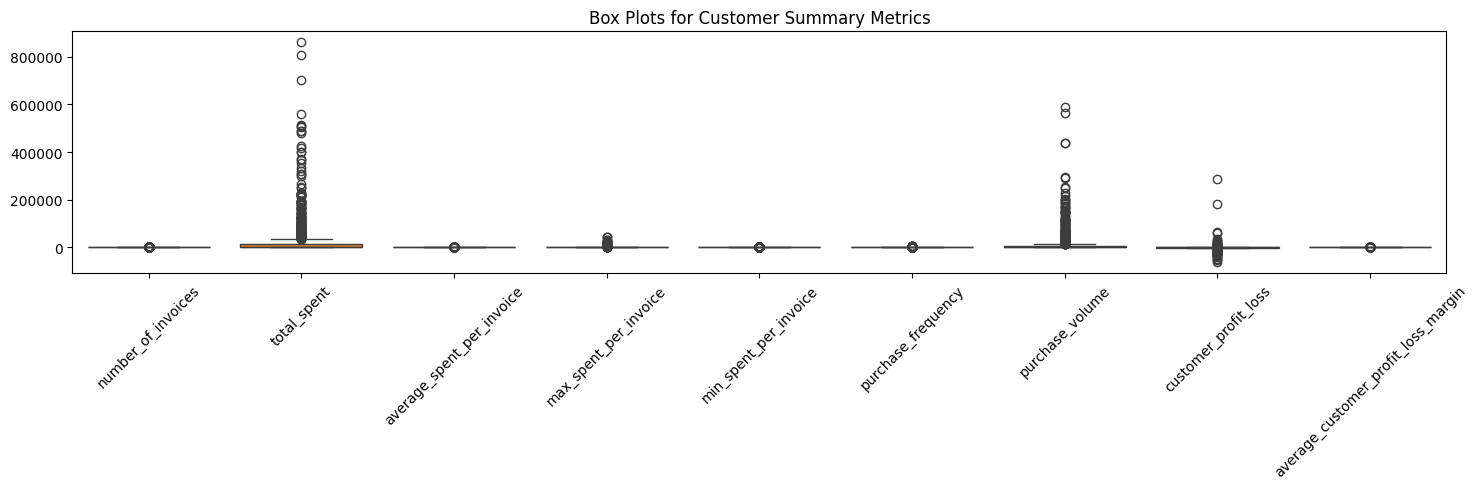

Number of customers after outlier removal: 1042


In [83]:
#Outlier detection in customer summary using Z-score
columns_to_check_customer = ['number_of_invoices', 'total_spent', 'average_spent_per_invoice',
                    'max_spent_per_invoice', 'min_spent_per_invoice',
                    'purchase_frequency', 'purchase_volume', 'customer_profit_loss', 'average_customer_profit_loss_margin']
df_outlier_check = df_customer_summary[columns_to_check_customer].copy()

z_scores = np.abs((df_outlier_check - df_outlier_check.mean()) / df_outlier_check.std())

#Flag customers with any Z-score > 3 as outliers
outlier_threshold = 3
outlier_flags = (z_scores > outlier_threshold).any(axis=1)

print(f"Number of customers flagged as outliers using Z-score: {outlier_flags.sum()} out of {len(df_customer_summary)}")
df_outliers_customer = df_customer_summary[outlier_flags]
display(df_outliers_customer)

#Outlier detection in customer summary using IQR
Q1 = df_customer_summary[columns_to_check_customer].quantile(0.25)
Q3 = df_customer_summary[columns_to_check_customer].quantile(0.75)
IQR = Q3 - Q1

IQR_outlier_flags = ((df_customer_summary[columns_to_check_customer] < (Q1 - 1.5 * IQR)) |
                        (df_customer_summary[columns_to_check_customer] > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"Number of customers flagged as outliers using IQR: {IQR_outlier_flags.sum()} out of {len(df_customer_summary)}")
df_IQR_outliers = df_customer_summary[IQR_outlier_flags]
display(df_IQR_outliers)

#Visualize outliers for customer summary using box plots
plt.figure(figsize=(15, 5))
sns.boxplot(data=df_customer_summary_cleaned[columns_to_check_customer])
plt.title('Box Plots for Customer Summary Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Outlier Removal
df_customer_summary_cleaned = df_customer_summary.loc[~outlier_flags].copy()
print(f"Number of customers after outlier removal: {len(df_customer_summary_cleaned)}")

After removing extreme outliers (Z-score > 3), the box plots reveal several important patterns in customer purchasing behaviour. Monetary variables such as total spent and purchase volume remain noticably right-skewed. This indicates that while most customers generate low revenue, a smaller group contributes disproportionately to sales. In contrast, behavioural metrics such as number of invoices or purchase frequency show tighter distribution.

Invoice-level metrics such as average spent per invoice and min spent per invoice show are also tightly distributed. Further highlighting spending habits on a per-transaction basis. Even more interesting, max-spent per invoice displays occasional higher spending values reflecting infrequent bulk or high-value orders.

Profitability metrics show quite a number of losses with only a small number of customers contributing to profits. Overall, the cleaned dataset indicates that customer base is summarized by relatively stable purchasing behaviour but barely any profit is achieved.

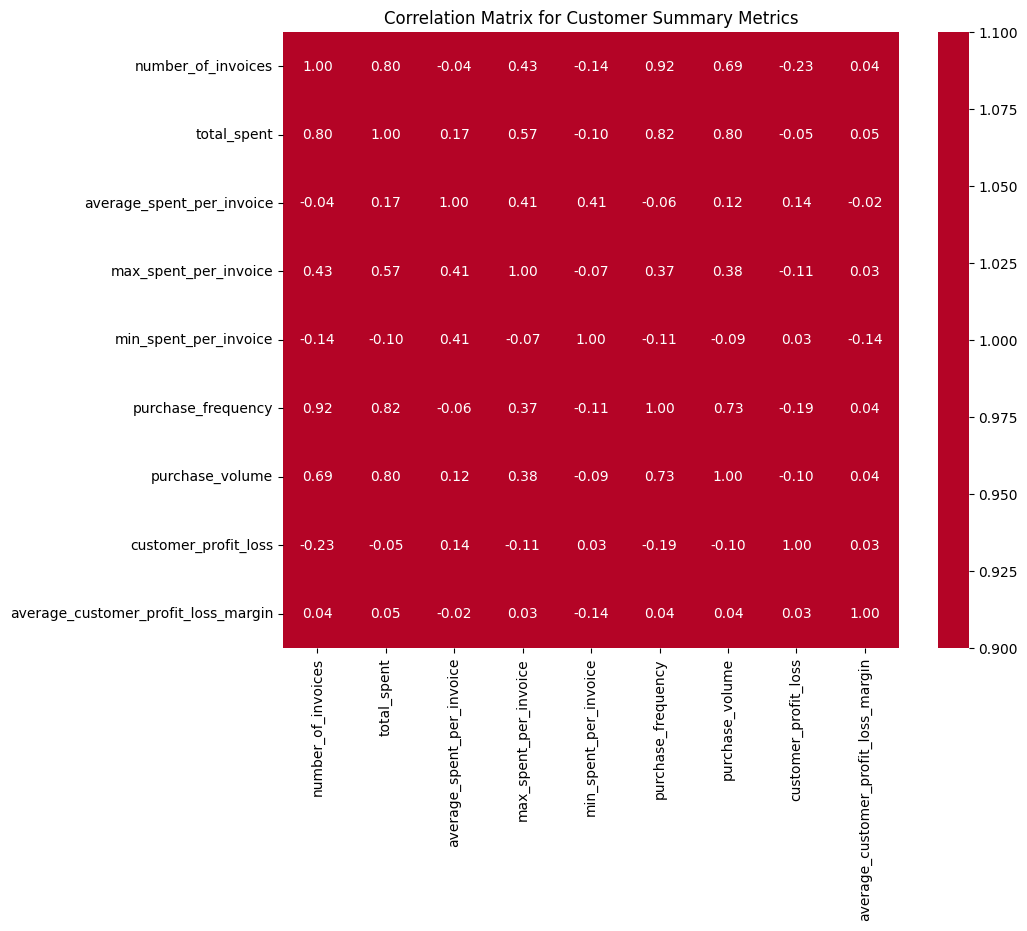

Variance Inflation Factor (VIF) for Customer Summary Metrics:


,feature,VIF
5,purchase_frequency,9.171907
0,number_of_invoices,8.296002
1,total_spent,6.373761
6,purchase_volume,3.261133
3,max_spent_per_invoice,2.365479
2,average_spent_per_invoice,2.150386
4,min_spent_per_invoice,1.471444
7,customer_profit_loss,1.174423
8,average_customer_profit_loss_margin,1.064729


In [53]:
#Check for correlations in customer summary metrics
correlation_matrix = df_customer_summary_cleaned[columns_to_check_customer].corr()

#Display correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',center=0, vmin=1, vmax=1, square=True)
plt.title('Correlation Matrix for Customer Summary Metrics')
plt.show()

#Check for multicollinearity using VIF
X = df_customer_summary_cleaned[columns_to_check_customer].copy()
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how='any')

#Drop constant columns if any
constant_columns = [col for col in X.columns if X[col].nunique() <= 1]
if constant_columns:
    print("Dropped constant columns:", constant_columns)
    X = X.drop(columns=constant_columns)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data.sort_values(by="VIF", ascending=False, inplace=True)
print("Variance Inflation Factor (VIF) for Customer Summary Metrics:")
display(vif_data)


When checked for correlation and multicollinearity, the Pearson correlation matrix was computed for all continuous variables and the Variance Inflation Factor method was used.

Strong positive correlations were observed between mutliple variables such as number of invoices, max spent for invoices and total spent. For other variables some correlation was found albeit with varying degrees of strength

For the multicollinearity calculation, a VIF above 10 was considered high potential multicollinearity and were considered for removal, transformation or dimensionality reduction. From the output above, no variable was found to have a VIF above 10.

# 2. One-Hot Encoding

## 2.1 Identify Relevant Features
Before applying clustering algorithms it is necessary to identify and select the most relevant features from the aggregated datasets. Feature selection was determined using the elbow and silhouette method for KMeans and a K-Distance plot was created to find the optimal eps for DBScans.

In [54]:
#Relevant Features based on previous analysis
feature_columns_customer = ['number_of_invoices', 'total_spent', 'average_spent_per_invoice', 'max_spent_per_invoice', 'purchase_volume', 'customer_profit_loss', 'average_customer_profit_loss_margin']

#Replace infinite / -infinite values with NaN and drop rows with NaN
df_customer_summary_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
df_customer_summary_cleaned.dropna(subset=feature_columns_customer, inplace=True)

#Scaling Features
scaler_customer = StandardScaler()
scaled_customer_features = scaler_customer.fit_transform(df_customer_summary_cleaned[feature_columns_customer])
df_customer_summary_scaled = pd.DataFrame(scaled_customer_features, columns=feature_columns_customer, index=df_customer_summary_cleaned.index)
display(df_customer_summary_scaled.head())

,number_of_invoices,total_spent,average_spent_per_invoice,max_spent_per_invoice,purchase_volume,customer_profit_loss,average_customer_profit_loss_margin
0,-0.474370,-0.351888,-0.592331,-0.431690,-0.303955,0.089142,0.108095
1,4.306265,8.570422,0.530207,0.597261,6.154483,0.905768,0.212204
2,-0.130309,-0.302882,-0.512917,-0.206580,-0.275023,0.030747,-0.002818
3,-0.438153,-0.295916,-0.107347,-0.213730,-0.300432,-0.087277,0.018684
4,-0.465316,-0.350717,-0.510429,-0.422073,-0.303911,0.088636,0.198988


The selection of features for customer clustering was based on both statistical diagnostics and domain relevance. First, a Pearson correlation matrix was computed to assess the relationships among all variables within the aggregated dataset. While some variables showed moderate to strong correlations (e.g. number of invoices and purchase frequency), none showed redundancy severe enough to warrant removal solely on the basis of correlation.

To further validate this, mulicolinnearity was assessed using the Variance Inflation Factor (VIF) where a threshold of 10 or higher was used to flag problematic predictors. As displayed above in the VIF table, no variables reached this threshold.

## 2.2 Elbow Method and Silhouette Scores
After selecting the final features, it is essential to identify the optimal number of clusters that best represents the structure of the data. Two complimentary techniques were applied: the Elbow method and the Silhouette Score.

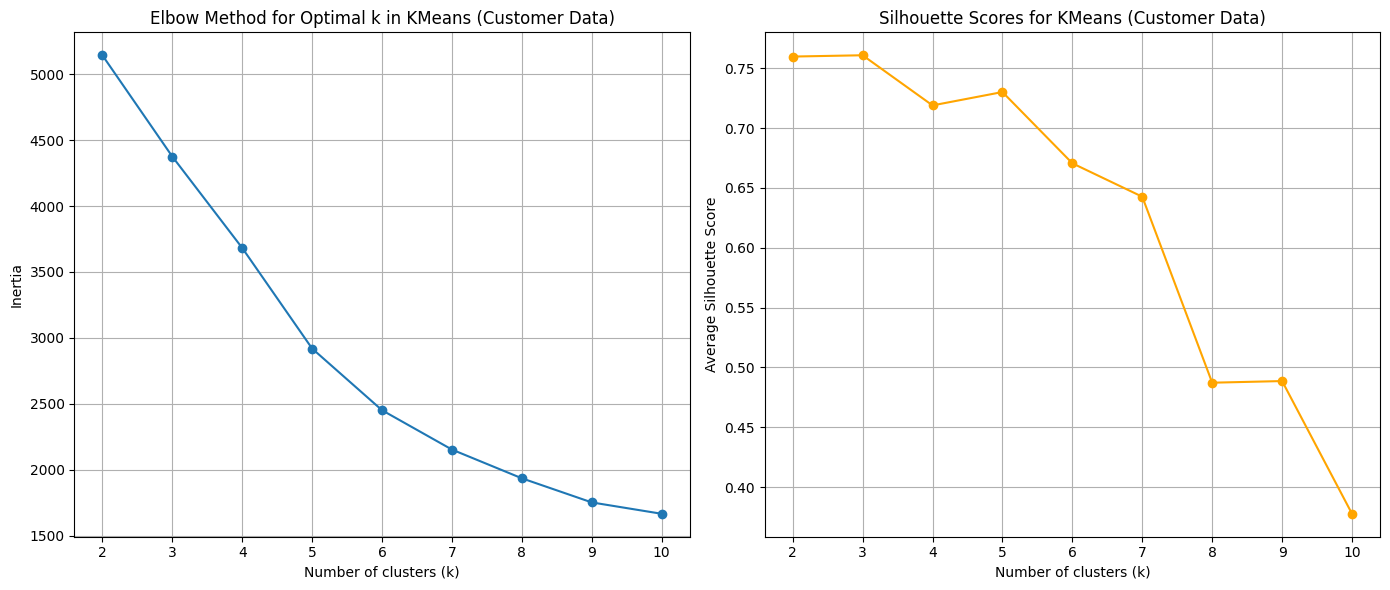

In [55]:
#Plotting Elbow Method and Silhouette Scores for KMeans on Customer Data -- IGNORE ---
inertia_values = []
silhouette_scores = []
k_range = range(2, 11)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_customer_summary_scaled)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_customer_summary_scaled, cluster_labels))

#Plot Elbow Method Figure
axes[0].plot(k_range, inertia_values, marker='o')
axes[0].set_title('Elbow Method for Optimal k in KMeans (Customer Data)')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_xticks(k_range)
axes[0].grid()

#Plot Silhouette Scores Figure
axes[1].plot(k_range, silhouette_scores, marker='o', color='orange')
axes[1].set_title('Silhouette Scores for KMeans (Customer Data)')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Average Silhouette Score')
axes[1].set_xticks(k_range)
axes[1].grid() 
plt.tight_layout()
plt.show()

To identify the optimal number of cluster for the KMeans alogrithm, both the elbow method and silhouette score analysis were applied. The elbow methods shows a steep decline in intertia starting from k=2 to k=5, after which the rate of improvement slows down considerably. This change in curvature indicates diminishing returns beyond 5 clusters.

The silhouette scores further supports this interpretation. While the highest value occurs at k=2 and then drops a bit, the drop is still moderate and reflects a well-separated cluster structure. However, after k=5, the score declines progressively, indicating weaker cohesion and separation as more clusters are added. 

Altogether, the elbow point at k=4 and the relatively strong silhouette score is evidence that four clusters offer the best balance between model simplicity and cluster quality for this customer segmentation.

## 2.3 K-Distance Plot

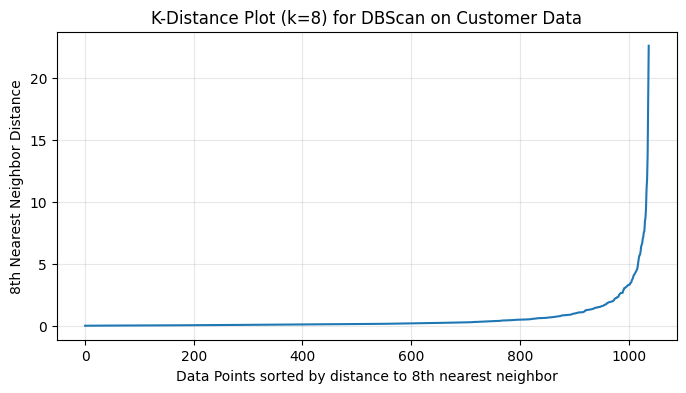

Suggested eps (auto-detected): 3.346


In [56]:
#K-Distance Plot for DBScan on Customer Data
X = df_customer_summary_scaled.values

k = 8  # Number of neighbors
neigbours = NearestNeighbors(n_neighbors=k)
neigbours_fit = neigbours.fit(X)
distances, indices = neigbours_fit.kneighbors(X)
k_distances = np.sort(distances[:, k-1])

#Plot K-Distance Plot
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title(f'K-Distance Plot (k={k}) for DBScan on Customer Data')
plt.xlabel('Data Points sorted by distance to {}th nearest neighbor'.format(k))
plt.ylabel('{}th Nearest Neighbor Distance'.format(k))
plt.grid(True, alpha=0.3)
plt.show()

#Detect the knee/elbow
kneedle = KneeLocator(
    range(len(k_distances)),
    k_distances,
    curve='convex',
    direction='increasing'
)

eps_auto = k_distances[kneedle.knee]
print(f"Suggested eps (auto-detected): {eps_auto:.3f}")

To determine an appropriate value for the DBScan distance parameter (eps), a k-distance plot was generated using the 8th nearest neighbor distance for each customer data point. The plot shows a relatively long, flat region followed by a sharp upward inflection, which represents the transition between dense regions (core points) and areas of sparse data (noise). 

The inflection point, also referred to as the "knee", corresponds to the optimal eps value at which DBScan most effectively separates dense clusters while avoiding noise. To identify this knee objectively, the Kneedle KneeLocator algorithm was applied, which detects the point of the maximum curvature in the ascending tail of the curve. The identified point was detected to be 3.346 which was rounded up to 3.4.

# 3. KMeans, DBScan and Hierarchical Clustering
After identifying and stadardizing the relevant features, three clustering algorithms were applied: KMeans Clustering, DBScan and Hierarchical Clustering. Each method provides a different perspective on the data structure and helps to validate the robustness of the resulting segments. 

/opt/anaconda3/envs/Business_Statistics/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


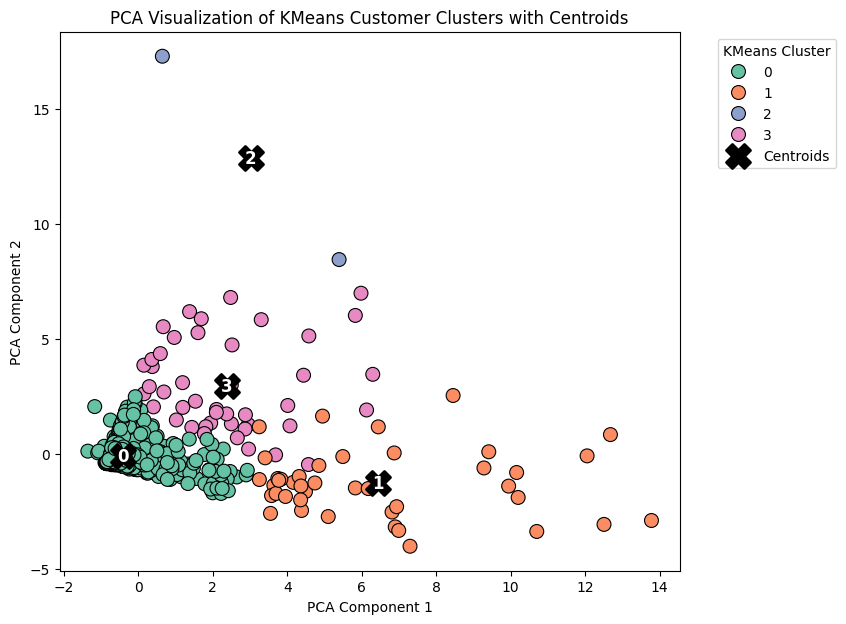

In [74]:
#KMeans Clustering on Customer Data
optimal_k_customer = 4  # Based on previous analysis
kmeans_customer = KMeans(n_clusters=optimal_k_customer, random_state=42)

#Save the data
df_customer_summary_cleaned['KMeans_cluster'] = kmeans_customer.fit_predict(df_customer_summary_scaled.values)

#Create a summary
cluster_summary = df_customer_summary_cleaned.groupby('KMeans_cluster').agg(
    number_of_customers=('customer', 'nunique'),

    # --- Spending Behavior ---
    avg_total_spent=('total_spent', 'mean'),
    avg_purchase_volume=('purchase_volume', 'mean'),
    avg_number_of_invoices=('number_of_invoices', 'mean'),
    avg_spent_per_invoice=('average_spent_per_invoice', 'mean'),
    avg_max_spent_per_invoice=('max_spent_per_invoice', 'mean'),
                               
    # --- Profitability Metrics---
    avg_customer_profit_loss=('customer_profit_loss', 'mean'),
    avg_customer_profit_loss_margin=('average_customer_profit_loss_margin', 'mean'),
                                     
    # --- Derived KPIs ---
    total_cluster_profit_loss=('customer_profit_loss', 'sum'),
    total_cluster_spent=('total_spent', 'sum')
).round(2)

#PCA Visualization of Customer Clusters (KMeans)
pca = PCA(n_components=2, random_state=42)
customer_pca = pca.fit_transform(df_customer_summary_scaled)

plt_df = pd.DataFrame({'PCA1': customer_pca[:, 0], 'PCA2': customer_pca[:, 1], 'KMeans_Cluster': df_customer_summary_cleaned['cluster'].to_numpy()})

#Project cluster centers to PCA space
centers_2d = pca.transform(kmeans_customer.cluster_centers_)
plt.figure(figsize=(8, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', data=plt_df, palette='Set2', s=100, edgecolor='k')

#Draw centroids
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='black', s=300, marker='X', label='Centroids', linewidths=2)
for i, (x, y) in enumerate(centers_2d):
    plt.text(x, y, str(i), color='white', fontsize=12, weight='bold', ha='center', va='center')
plt.title('PCA Visualization of KMeans Customer Clusters with Centroids')
plt.legend(title='KMeans Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## 3.1 Interpretation of KMeans Clustering
The KMeans clustering performed using the standardized aggregated customer dataset identified four distinct customer groups, each representing unique behavioural customer segments. The PCA visualization clearly highlights the separation between clusters, with cluster 0 forming the densest group, cluster 1 forming a more dispersed high-value segment and clusters 2 and 3 positioning themselves as outliers or transitional segments.

Cluster 0 (n=950) - This cluster represents the core customer base, characterized by balanced purchasing volume, moderate total spending and stable profit/loss.

Cluster 1 (n=42) - This cluster represents a small group of high-spending customers with greater purchasing volume and transaction size. These customers most likely account for a significant share of the company's total revenue.

Cluster 2 (n=2) - This cluster represents two extreme outliers displaying extreme values in spending or profit metrics. 

Cluster 3 (n=44) - The final cluster represents moderate-to-high value customers with consistent purchasing patterns and above average margins.

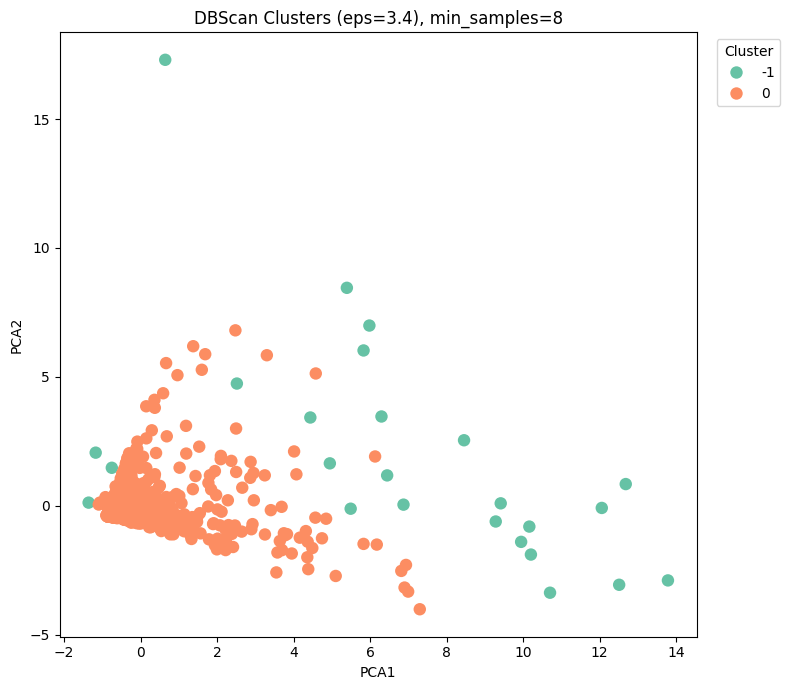

In [73]:
#DBScan Clustering on Customer Data
eps = 3.4 #From Kneelocator
min_samples = 8
dbscan_customer = DBSCAN(eps, min_samples=min_samples)

#Save the data
labels = dbscan_customer.fit_predict(df_customer_summary_scaled.values)
df_customer_summary_cleaned['DBScan_cluster'] = labels

#PCA Visualization of Customer Clusters (DBScan)
pca = PCA(n_components=2, random_state=42)
customer_pca = pca.fit_transform(df_customer_summary_scaled)

plot_df = pd.DataFrame({'PCA1': customer_pca[:, 0],
                        'PCA2': customer_pca[:, 1],
                        'Cluster': labels})

#Plot DBScans
plt.figure(figsize=(8,7))

noise_mask = plot_df['Cluster'] == -1
valid_mask = ~noise_mask

#Noise Plotting
sns.scatterplot(data=plot_df[noise_mask], x='PCA1', y='PCA2', s=50, edgecolor='none')

#Cluster Plotting
if valid_mask.any():
    sns.scatterplot(x='PCA1', y='PCA2', data=plot_df, s=80, edgecolor='none', palette='Set2', hue='Cluster')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Cluster')
else:
    plt.legend()

plt.title(f'DBScan Clusters (eps={eps}), min_samples={min_samples}')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.tight_layout()
plt.show()

## 3.2 Interpretation of DBScan Clustering
Based on the results of the DBScan clustering algorithm which was applied using an eps value of 3.4 and a minimum sample size of 8, based on the knee detected using the Kneedle KneeLocator. Under these parameters, DBScan identified two groups within the dataset: one dense core cluster and a noise group.

Cluster 0 (n=1,013) - This represents the primary customer group located in the densest region of the PCA. This group can be characterized by stable and consistent purchasing behaviour. DBScan's assignment of the majority of customers to this single cluster suggests that it recognizes one dominant behavioural patterns within the dataset, with most customers falling within this feature space.

Cluster -1 (n=25) -  This group was identified as noise, in other words customers with outlier behaviors. They lie outside the dense regions defined by the eps threshold. These include customers with extreme purchasing behaviours and unusually high or low spending levels. Their dispersion within the figure confirms that these customers differ significantly from the dense core group and cannot be grouped meaningfully.

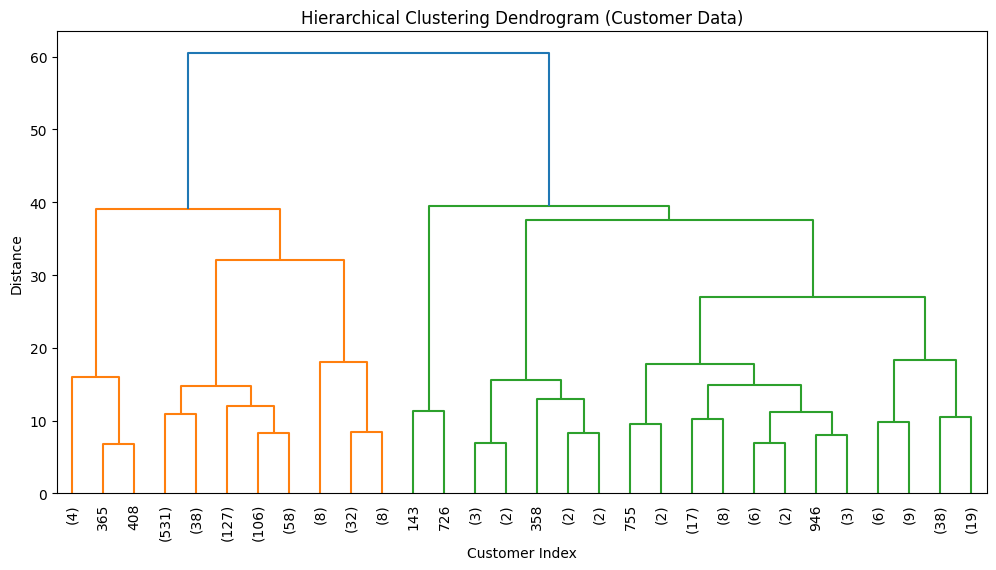

In [72]:
#Hierarchical Clustering on Customer Data -- IGNORE ---
X_hierarchy = df_customer_summary_scaled.values

#Compute linkage matrix using Ward
Z = linkage(X_hierarchy, method='ward')

#Plot Dendogram
plt.figure(figsize=(12,6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Customer Data)')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.show()

#Save the data
df_customer_summary_cleaned['Hierarchical_cluster']=fcluster(Z, t=4, criterion='maxclust')

## 3.3 Interpretation of Hierarchical Clustering
The hierarchical clustering dendogram reveals a clear separation between several distinct customer segments. Using Ward's linkage method, the dendogram shows a major split at a high-distance threshold, separating the dataset into two large branches, one denser and another more dispersed. This division suggests the presence one dominant customer group and several smaller subgroups. After cutting the dendogram into four clusters, the follwing patters emerge:

Cluster 2 Dominant Core Segment (n=908) - This cluster contains the highest proportion of customers in the entire figure. Customers in this group display moderate spending levels, stable invoice counts and consistent purchase behaviour, similar to those identified in the KMeans clusters.

Cluster 4 Higher Value Customers (n=122) - This cluster forms a distinct branch in the dendogram. These customers exhibit high spending, purchase frequency and transaction volume. Placing them above the core segment in value. This separation in the dendogram reflects meaningful behaviour.

Clusters 1 and 3 Outlier Segments (n=6, n=2) - These two clusters consist of much smaller sets of customers who deviate substantially from the average. They show unusual or extreme patters which may include very high or low spending and atypical invoice amounts. Their placement at the outer branches of the dendogram indicates that they do not align with the other segments whatsoever.

## 3.4 Overview of Clustering Data for furhter use

In [71]:
print("KMeans Cluster Counts:")
display(df_customer_summary_cleaned['KMeans_cluster'].value_counts().sort_index())
print("")
print("DBScan Cluster Counts:")
display(df_customer_summary_cleaned['DBScan_cluster'].value_counts().sort_index())
print("")
print("Hierarchical Cluster Counts:")
display(df_customer_summary_cleaned['Hierarchical_cluster'].value_counts().sort_index())
print("")

KMeans Cluster Counts:


KMeans_cluster
0    950
1     42
2      2
3     44
Name: count, dtype: int64


DBScan Cluster Counts:


DBScan_cluster
-1      25
 0    1013
Name: count, dtype: int64


Hierarchical Cluster Counts:


Hierarchical_cluster
1      6
2    908
3      2
4    122
Name: count, dtype: int64

A comparison across the three clustering methods reveals that each algorithm captures different perspectives based on the customer dataset. KMeans identified four clusters with a clear dominant group and three smaller segments including a pair of extreme outlier and two mid-value customer groups.

DBScan in contrast extracted one dense core cluster and flagged 25 customers as noise. Indicating that most consumers fall within a single-high density region.

Hierarchical clustering provided an intermediate structure. With 4 clusters consisting of one very large group and three smaller branches which aligns with what was observed in KMeans. 

The consistency between these two suggests that the datset contain clear but unevenly sized customer segments, while DBScan reinforces the presence of a dense main customer segments with a small set of outliers.

# 4. Hypothesis Testing
After performing customer segmentation using clustering algorithms(KMeans, DBScan and Hierarchical Clustering), this section aims to statistically validate one of the key behavioural patterns observed during the analysis. Namely, the relationship between purchase volume and total profit/loss.

As stated earlier the personal research subquestion for this research is: Is there a significant relationship between profit/loss and purchase volume across customer segments?

The following hypotheses have been created to test this:
H0: There is no significant relationship between purchase volume and profit/loss across all segments
HA: There is a significant relationship between purchase volumen and profit/loss across all segments

For the analysis, two types of correlation coefficients are computed using:
Pearson's r
Spearman's rho

Overall Correlation across all customers:
                       cluster  customer_profit_loss  purchase_volume
cluster               1.000000              0.000906         0.286868
customer_profit_loss  0.000906              1.000000        -0.091651
purchase_volume       0.286868             -0.091651         1.000000

Pearson correlation: r = -0.092, p-value = 0.0031, 95% CI = (-0.152, -0.031), n = 1038
Spearman correlation: ρ = -0.458, p-value = 0.0000


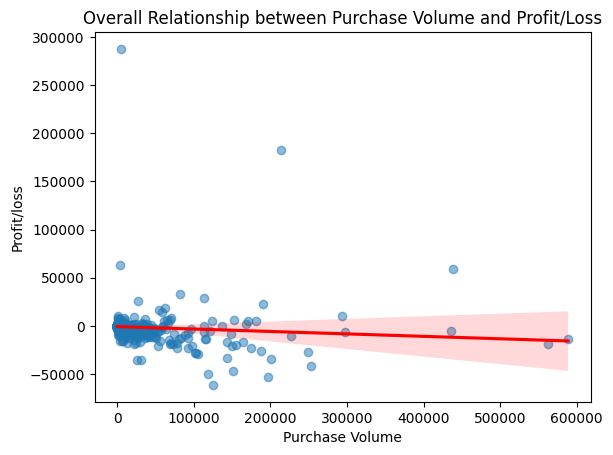

In [61]:
#Correlation Analysis Post-Clustering
df_corr = df_customer_summary_cleaned[['cluster', 'customer_profit_loss', 'purchase_volume']].dropna()
print('Overall Correlation across all customers:')
print(df_corr.corr())
print("")

#Pearson correlation per cluster (linear relationship)
r, p_value = stats.pearsonr(df_corr['customer_profit_loss'], df_corr['purchase_volume'])

#Compute 95% confidence intervals for Pearson correlation
n = len(df_corr)
Z_r = np.arctanh(r) if abs(r) < 1 else np.sign(r) * np.inf
SE = 1 / np.sqrt(n - 3) if n > 3 else np.nan
z_critical = 1.96  # for 95% confidence
ci_lower = np.tanh(Z_r - z_critical * SE)
ci_upper = np.tanh(Z_r + z_critical * SE)

#Spearman correlation
rho, p_rho = stats.spearmanr(df_corr['customer_profit_loss'], df_corr['purchase_volume'])

#Print correlation results
print(f"Pearson correlation: r = {r:.3f}, p-value = {p_value:.4f}, 95% CI = ({ci_lower:.3f}, {ci_upper:.3f}), n = {n}")
print(f"Spearman correlation: ρ = {rho:.3f}, p-value = {p_rho:.4f}")

#Visualization (overall relationship)
sns.regplot(x='purchase_volume', y='customer_profit_loss', data=df_corr, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Overall Relationship between Purchase Volume and Profit/Loss')
plt.xlabel('Purchase Volume')
plt.ylabel('Profit/loss')
plt.show()



The scatter plot and correlation statistics provide insight into the relationship between customers' purchase volume and profit/loss generated by them. Visually, the data shows a dense cluster customers and little to no profit (mainly loss). Accompanied by these dense clusters are a small number of outliers which contribute generate large amounts of profit. 

The Pearson correlation confirms that there is a weak negative linear relationsip between purchase volume and porfit. Based on the results (r=-0.092 p=0.0031) the linear association is practically negligable in practical terms. In other words, based on the Pearson correlation high purchase volume is not reliably associated with higher or lower profit generated.

In contrast, the Spearman rank correlation indicates a moderate negative relationship (rho=-0.0458, p=0.0000). This suggests that when ranking customers from low to high purchase volume, those with higher volumes tend to occupy lower positions in terms of profitability. This discrepancy between Pearson and Spearman implies that non-linear behaviour.

Correlation per KMeans Cluster:


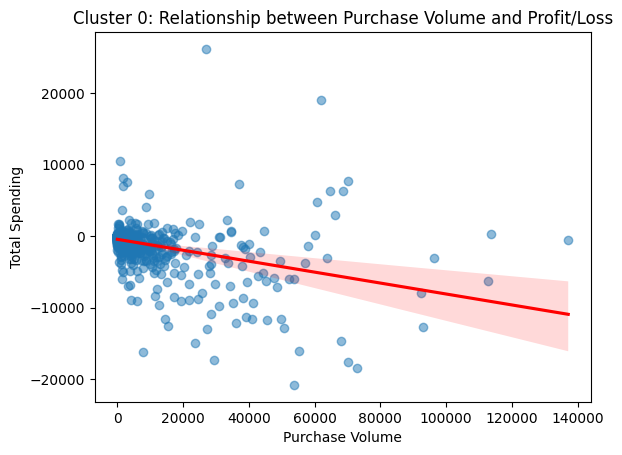

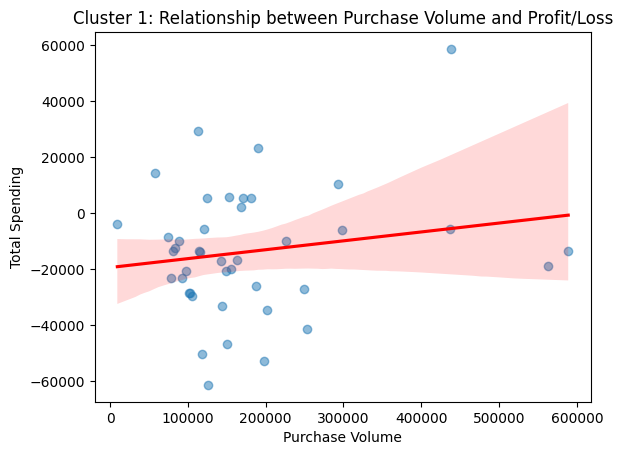

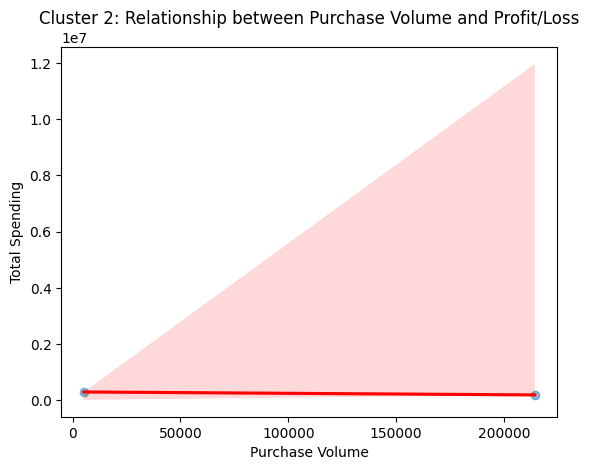

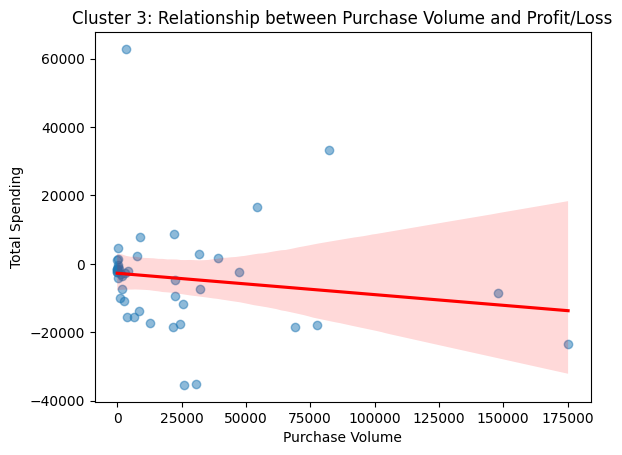

In [62]:
#Correlation per cluster
print("Correlation per KMeans Cluster:")
cluster_results = []

for cluster in sorted(df_corr['cluster'].unique()):
    cluster_data = df_corr[df_corr['cluster'] == cluster]
    r_cluster, p_value_cluster = stats.pearsonr(cluster_data['customer_profit_loss'], cluster_data['purchase_volume'])
    n_cluster = len(cluster_data)
    
    # Compute 95% confidence intervals for Pearson correlation
    Z_r_cluster = np.arctanh(r_cluster) if abs(r_cluster) < 1 else np.sign(r_cluster) * np.inf
    SE_cluster = 1 / np.sqrt(n_cluster - 3) if n_cluster > 3 else np.nan
    ci_lower_cluster = np.tanh(Z_r_cluster - z_critical * SE_cluster)
    ci_upper_cluster = np.tanh(Z_r_cluster + z_critical * SE_cluster)
    
    rho_cluster, p_rho_cluster = stats.spearmanr(cluster_data['customer_profit_loss'], cluster_data['purchase_volume'])
    
    cluster_results.append({
        'Cluster': cluster,
        'Pearson_r': r_cluster,
        'Pearson_p_value': p_value_cluster,
        'Pearson_CI_Lower': ci_lower_cluster,
        'Pearson_CI_Upper': ci_upper_cluster,
        'Spearman_rho': rho_cluster,
        'Spearman_p_value': p_rho_cluster,
        'n': n_cluster
    })

#Visualization per cluster
    sns.regplot(x='purchase_volume', y='customer_profit_loss', data=cluster_data, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    plt.title(f'Cluster {cluster}: Relationship between Purchase Volume and Profit/Loss')
    plt.xlabel('Purchase Volume')
    plt.ylabel('Total Spending')
    plt.show()

To better understand how the relationship between purchase volume and profitability differs between customer segments, the same correlation analysis was conduceted separately for each KMeans cluster. The scatter plot and regression lines illustrate the direction and strength of these relationships.

Cluster 0 (Core Customer Base) Weak Positive Relationship - Cluster 0 contains the majority of customers. In their case purchase volume shows a weak negative linear relationship with profit/loss. As purchase volume increases, profit/loss generated declines slightly. This pattern likely reflects cost structures, discounting or operational inefficiencies associated with higher-volume but low-margin customers. The dense cluster points and flat slope indicate that profitability varies only minimally with purchase volume in this segment.

Cluster 1 (High-Spending Customers) Weak Positive Relationship - Cluster 1 shows a small positive association between purchase volume and profit/loss. Higher-volume customers in this segment tend to generate slightly better profit outcomes, although the relationship remain noisy and confidence interval is wide due to the small sample size. These customers likely benefit from more efficient order patterns or higher-priced products, resulting in modest increases in profitablity as their purchase volume increases.

Cluster 2 (Extreme Outliers) Indeterminable Relationship - Cluster 2 contains only two data points both of which exhibit high spending but do not provide a meaningful relationship due to the extremely small sample size. Therefore,for this cluster no interpretable relationship can be established.

Cluster 3 (Mid-Value Customers) Moderate Negative Relationship - Cluster 3 displays a moderate negative relationship between purchase volume and profit/loss. As purchase volume increases within this group, profitability declines more noticably. This behaviour suggests that consumers in this segment may receive volume-based discounts or buy lower-margin items, causing profit to decrease at higher purchase volumes.

## 4.1 Analysis of Spearman and Pearson
The correlation analysis examined the relationship between purchase volume and profit/loss across all customer clusters. The results show a statistically significant but weak negative correlation between purchase volume and profit/loss. This suggests that on average customers who purchase more tend to generate lower profits. The stronger Spearman corelation indicates that the relationship is not strictly linear. The negative trend continues even when ranking the data, which implies a general decline in profitability with higher volume purchases. These findings may reflect volume discounting or diminishing profit margins among high-volume customers.

In [63]:
display(df_cluster_results := pd.DataFrame(cluster_results))

,Cluster,Pearson_r,Pearson_p_value,Pearson_CI_Lower,Pearson_CI_Upper,Spearman_rho,Spearman_p_value,n
0,0,-0.376335,2.496038e-33,-0.429656,-0.320399,-0.468163,6.477046e-53,950
1,1,0.175347,2.666906e-01,-0.135829,0.455033,0.050482,7.508712e-01,42
2,2,-1.000000,1.000000e+00,NaN,NaN,-1.000000,NaN,2
3,3,-0.148134,3.372429e-01,-0.426272,0.155595,-0.309373,4.100255e-02,44


In [64]:
#Extract profit/loss by cluster
groups = [df_customer_summary_cleaned.loc[df_customer_summary_cleaned['cluster'] == i, 'customer_profit_loss']
          for i in sorted (df_customer_summary_cleaned['cluster'].unique())]

#Check for normality
for i, g in enumerate(groups):
    print(f"Cluster{i}: mean={g.mean():.2f}, std={g.std():.2f}, n={len(g)}")

#Run ANOVA (parametric)
anova_stat, anova_p = f_oneway(*groups)
print(f"\nAnova: F={anova_stat:.3f}, p-value={anova_p:.5f}")

#Run Kruskal-Wallis (non-parametric)
kw_stat, kw_p = kruskal(*groups)
print(f"Kruskal-Wallis: H={kw_stat:.3f}, p-value{kw_p:.5f}")

Cluster0: mean=-917.82, std=2885.07, n=950
Cluster1: mean=-13800.45, std=22667.34, n=42
Cluster2: mean=235047.22, std=74340.61, n=2
Cluster3: mean=-4189.41, std=15834.04, n=44

Anova: F=904.110, p-value=0.00000
Kruskal-Wallis: H=54.770, p-value0.00000


## 4.2 Analysis of Anova and Kruskal-Wallis
To further evaluate whether profitability differs between customer segments, both one-way Anova and Kruskal-Wallis tests were performed.

Both tests reject the null hypothesis (H0) that the mean profit/loss is equal across clusters. This confirms that profitability varies significantly among customer segments.

Cluster 0 (n=950) is slightly loss-making but stable and represents the majority of the customer base. Cluster 1 (n=42) has the highest level of losses which suggests these buyers are price-sensitive. Cluster 2 (n=2) are the most exceptional among the group of customers in terms of profitability. Cluster 3 (n=44) contains moderate losses and are indicitative of medium-volume buyers.